In [1]:
from matplotlib import pyplot as plt
import numpy as np

import prizmatoid as pzt
import metadatabase as mdb
try:
    reload(pzt)
    reload(mdb)
except:
    from importlib import reload
    reload(pzt)
    reload(mdb)

## Metadatabase

Here we demonstrate how to simultaneously load multiple data chunks using the new PRIZM metadatabase and its utility functions. We begin by setting the directories where the data and data patches are located:

In [3]:
mdb.data_directory = '/Volumes/PRIZM_DISK1'
mdb.patches_directory = '../patches_data'

Next, specify the time intervals and PRIZM components of interest. Here we also add an additional requirement (or filter) that all loaded data should have the 'polarization_1' channel available.

In [2]:
ctime_intervals = [(1524600000, 1524700000), (1524700000, 1524800000)]
components=['70MHz', 'switch']
filters=['polarization_1']

In [ ]:
prizm_data = mdb.load_multiple_data(ctime_intervals, components, filters, patch=True, verbose=False)

Notice also that the above `load_multiple_data` function automatically applies the necessary patches to the data of interest. This includes trimming glitchy portions of the data, correcting timestamp issues, and ignoring corructed data.

The `prizm_data` dictionary is backwards compatible with all `prizmatoid` functions, so all data operations from before should work as intended. Below we go through some of the same manipulations demonstrated in previous Jupyter notebooks:

In [ ]:
prizm_data['switch']

In [ ]:
prizm_data['70MHz']

In [ ]:
prizm_data['70MHz']['pol0.scio']

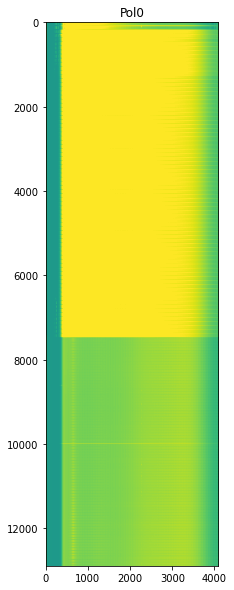

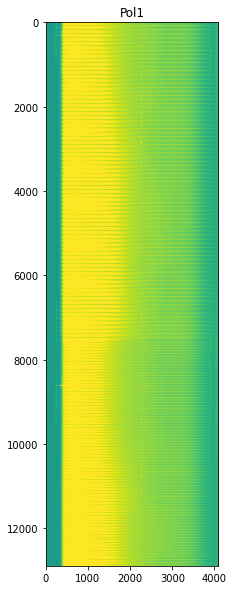

In [4]:
# Plots the polarization channel 'Pol0' on a logarithmic color scale.
plt.figure(1, figsize=(10, 10))
plt.title('Pol0')
plt.imshow(np.log10(prizm_data['70MHz']['pol0.scio']), vmin=4.5, vmax=8.5)

# Plots the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(2, figsize=(10, 10))
plt.title('Pol1')
plt.imshow(np.log10(prizm_data['70MHz']['pol1.scio']), vmin=4.5, vmax=8.5)

Here we plot the `time_sys_start.raw` and `time_sys_stop.raw` entries of `prizm_data` dictionary

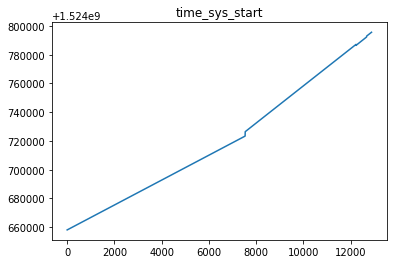

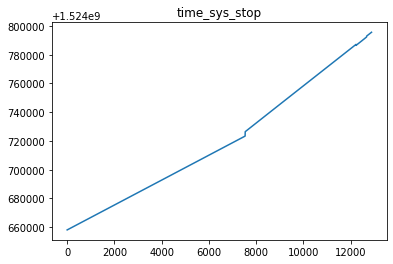

In [5]:
# Plots the timestamp 'time_sys_start.raw' data associated with 70MHz antenna.
plt.figure(1)
plt.title('time_sys_start')
plt.plot(prizm_data['70MHz']['time_sys_start.raw'])

# Plots the timestamp 'time_sys_stop.raw' data associated with 70MHz antenna.
plt.figure(2)
plt.title('time_sys_stop')
plt.plot(prizm_data['70MHz']['time_sys_stop.raw'])

The function `add_switch_flags` adds a new entry to `prizm_data` containing information which allows us to separate the data collected during different operation modes.

In [6]:
pzt.add_switch_flags(prizm_data, antennas=['70MHz'])

Similarly, we can generate the temperature flags with `add_temp_flags`, nighttime flags with `add_nighttime_flags`, and Moon flags with `add_moon_flags`.

In [18]:
pzt.add_temp_flags(prizm_data, antennas=['70MHz'])
pzt.add_nighttime_flags(prizm_data, antennas=['70MHz'])
pzt.add_moon_flags(prizm_data, antennas=['70MHz'], altitude_buffer=0.25)

If everything worked well with the above lines of code, the data flags should be stored in new entries of the data dictionary called `'switch_flags'`, `'temp_flags'`, `'nighttime_flags'`, and `moon_flags`.

In [10]:
prizm_data['70MHz']['switch_flags']

{'antenna.scio': array([0, 0, 0, ..., 1, 1, 1]),
 'noise.scio': array([0, 0, 0, ..., 0, 0, 0]),
 'res100.scio': array([0, 0, 0, ..., 0, 0, 0]),
 'res50.scio': array([0, 0, 0, ..., 0, 0, 0]),
 'short.scio': array([0, 0, 0, ..., 0, 0, 0])}

In [19]:
prizm_data['70MHz']['temp_flags']

array([1, 0, 0, ..., 0, 0, 0])

In [20]:
prizm_data['70MHz']['nighttime_flags']

array([0, 0, 0, ..., 1, 1, 1])

In [21]:
prizm_data['70MHz']['moon_flags']

array([ 1,  1,  1, ..., -1, -1, -1])

Each of the `'switch_flags'` entries is a NumPy array containing 0's and 1's which can be used to select the parts of the data associated with each observing mode. The four observing modes are the following:

- `'antenna.scio'`: the mode in which the antenna is observing the sky.
- `'res100.scio'`: the mode in which the instrument records the load from an internal 100 Ohm resistor. 
- `'res50.scio'`: the mode in which the instrument records the load from an internal 50 Ohm resistor. 
- `'short.scio'`: the mode in which the instrument is shorted, and therefore records only internally generated signals.
- `'noise.scio'`: the mode in which the instrument records the signal from an internal noise source.

To create filters capable of selecting the data associated with each of these modes, use the following expressions which transform the `1` and `0` entries of each flag arrays into `True` and `False`, respectively. (Here we also use the `shrink_flag` function to crop the first and last samples of each flag field).

In [24]:
# Stores the different flags into NumPy arrays.
select_antenna = (pzt.shrink_flag(prizm_data['70MHz']['switch_flags']['antenna.scio'], (1,1)) == 1)
select_res100 = (pzt.shrink_flag(prizm_data['70MHz']['switch_flags']['res100.scio'], (1,1)) == 1)
select_res50 = (pzt.shrink_flag(prizm_data['70MHz']['switch_flags']['res50.scio'], (1,1)) == 1)
select_short = (pzt.shrink_flag(prizm_data['70MHz']['switch_flags']['short.scio'], (1,1)) == 1)
select_noise = (pzt.shrink_flag(prizm_data['70MHz']['switch_flags']['noise.scio'], (1,1)) == 1)
select_temp = (prizm_data['70MHz']['temp_flags'] == 1)

We can check that these flags make sense by plotting them together as follows.

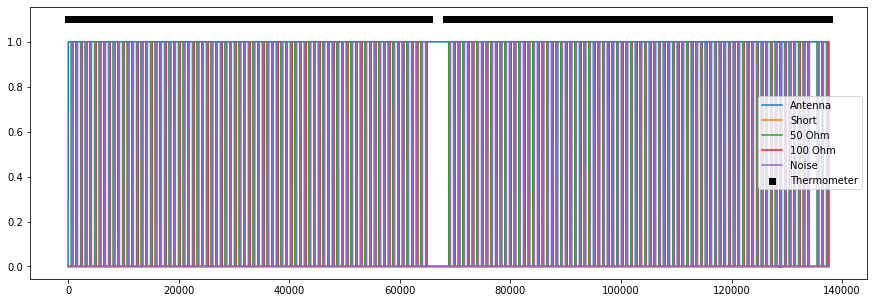

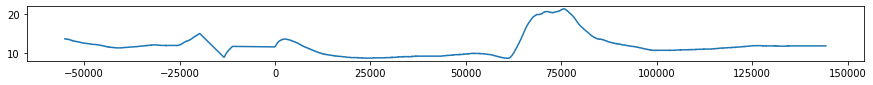

In [26]:
# Plots the different flags.
plt.figure(1, figsize=(15, 5))

# Uses the `prizm_data['70MHz']['time_sys_start.raw'][0]` as a time reference for both the switch states and
# the thermometer measurements.
data_time = prizm_data['70MHz']['time_sys_start.raw'] - prizm_data['70MHz']['time_sys_start.raw'][0]
therm_time_start = prizm_data['switch']['time_start_therms.raw'] - prizm_data['70MHz']['time_sys_start.raw'][0]
therm_time_stop = prizm_data['switch']['time_stop_therms.raw'] - prizm_data['70MHz']['time_sys_start.raw'][0]

# Show when each observing mode is active as a function of time.
plt.plot(data_time, select_antenna, label='Antenna')
plt.plot(data_time, select_short, label='Short')
plt.plot(data_time, select_res50, label='50 Ohm')
plt.plot(data_time, select_res100, label='100 Ohm')
plt.plot(data_time, select_noise, label='Noise')
plt.scatter(data_time[select_temp > 0], select_temp[select_temp > 0]*1.1, label='Thermometer', marker='s', color='black')

# Legend and x-axis range.
plt.legend(loc='best')
#plt.xlim([7500,11000])
#plt.xlim([3000,5000])


# Plots one of the ambient temperature readings.
plt.figure(2, figsize=(15, 1))

# Shows the actual ambient temperature readings for the 100MHz antenna as a function of time.
plt.plot(therm_time_start, prizm_data['switch']['temp_70A_noise.raw'], label='T_amb')

# Legend and x-axis range.
#plt.legend(loc='best')
#plt.xlim([3000,5000])

Notice how the observation modes alternate. The mode given by `antenna.scio` is the one that lasts the longest, since it is recording the actual signal coming from the sky. The about of time spent in the observation modes given by `short.scio`, `res50.scio`, and `res100.scio` is much smaller. Nonetheless, these modes must be switched on periodically throughout the instrument's operation since the information collected by them is needed for calibrating the data. The black bands on the top of the plot indicate the periods of time when the intrument's thermometers were performing measurements.

Notice also from the plot below how the ambient temperature measurements vary much less abrptuly during nighttime.

(0.0, 137640.93822026253)

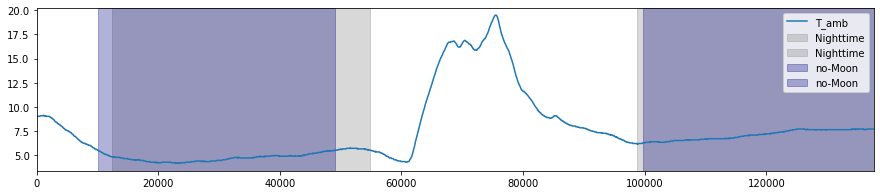

In [27]:
# Plots one of the ambient temperature readings.
plt.figure(2, figsize=(15, 3))

# Finds the boundaries of nighttime.
night_flag = np.ma.masked_array(prizm_data['70MHz']['nighttime_flags'], mask=prizm_data['70MHz']['nighttime_flags'])
night_clumps = np.ma.clump_masked(night_flag)

# Finds the time intervals when the Moon is below the horizon.
moon_flag = np.ma.masked_array(prizm_data['70MHz']['moon_flags'], mask=(prizm_data['70MHz']['moon_flags']==-1))
moon_clumps = np.ma.clump_masked(moon_flag)

# Plots the nighttime regions with a gray background.
for clump in night_clumps:
    plt.axvspan(data_time[np.r_[clump][0]], data_time[np.r_[clump][-1]], alpha=0.3, color='gray', label='Nighttime')
    
# Plots the no-Moon regions with a gray background.
for clump in moon_clumps:
    plt.axvspan(data_time[np.r_[clump][0]], data_time[np.r_[clump][-1]], alpha=0.3, color='navy', label='no-Moon')

# Shows the actual ambient temperature readings for the 100MHz antenna as a function of time.
plt.plot(therm_time_start, prizm_data['switch']['temp_100_ambient.raw'], label='T_amb')

# Legend and x-axis range.
plt.legend(loc='best')
plt.xlim([data_time.min(), data_time.max()])

Since the flags generated above are composed of entries which are either `True` or `False`, they can be used to slice the data and extract any observing mode of interest. Below we perform this selection.

In [9]:
# Selects the data from the 'pol0.scio' channel associated with the different observing modes.
antenna_data_pol0 = prizm_data['70MHz']['pol0.scio'][select_antenna]
res100_data_pol0 = prizm_data['70MHz']['pol0.scio'][select_res100]
res50_data_pol0 = prizm_data['70MHz']['pol0.scio'][select_res50]
short_data_pol0 = prizm_data['70MHz']['pol0.scio'][select_short]
noise_data_pol0 = prizm_data['70MHz']['pol0.scio'][select_noise]

# Selects the data from the 'pol1.scio' channel associated with the different observing modes.
antenna_data_pol1 = prizm_data['70MHz']['pol1.scio'][select_antenna]
res100_data_pol1 = prizm_data['70MHz']['pol1.scio'][select_res100]
res50_data_pol1 = prizm_data['70MHz']['pol1.scio'][select_res50]
short_data_pol1 = prizm_data['70MHz']['pol1.scio'][select_short]
noise_data_pol1 = prizm_data['70MHz']['pol1.scio'][select_noise]

The data associated with the antenna observations alone can now be plotted independently.

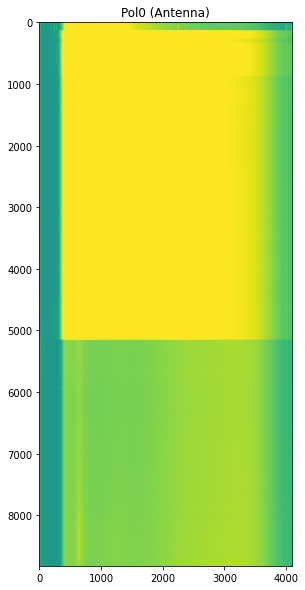

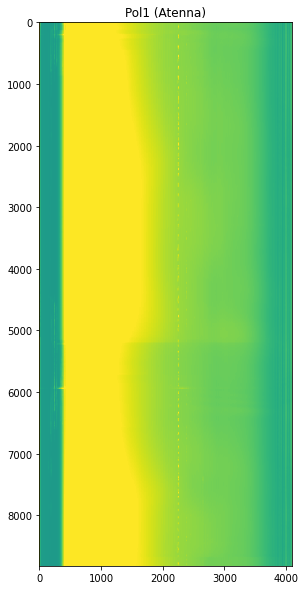

In [10]:
# Plots the 'antenna.scio' mode for the polarization channel 'Pol0' on a logarithmic color scale.
plt.figure(1, figsize=(10, 10))
plt.title('Pol0 (Antenna)')
plt.imshow(np.log10(antenna_data_pol0), vmin=4.5, vmax=8.5)

# Plots the 'antenna.scio' mode for the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(2, figsize=(10, 10))
plt.title('Pol1 (Atenna)')
plt.imshow(np.log10(antenna_data_pol1), vmin=4.5, vmax=8.5)

Below we show the the analogous plots for the `short.scio`, `res50.scio`, and `res100.scio` observing modes associated with the `pol0.scio` channel.

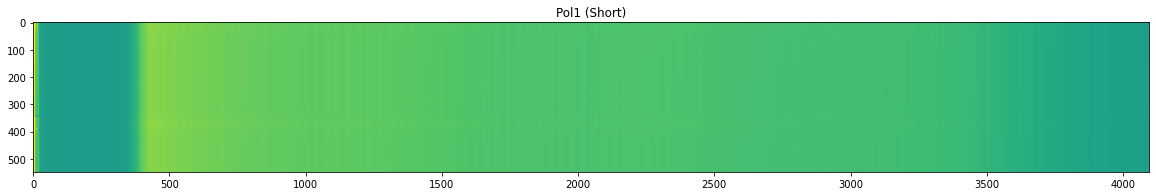

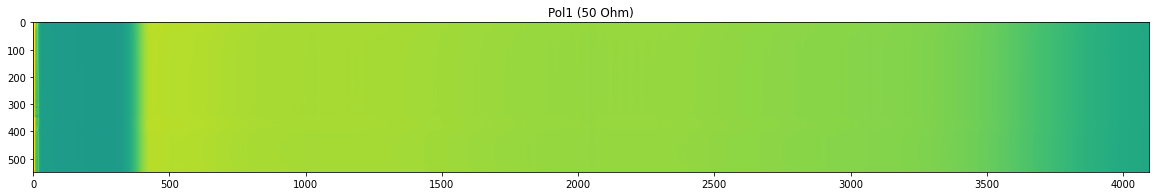

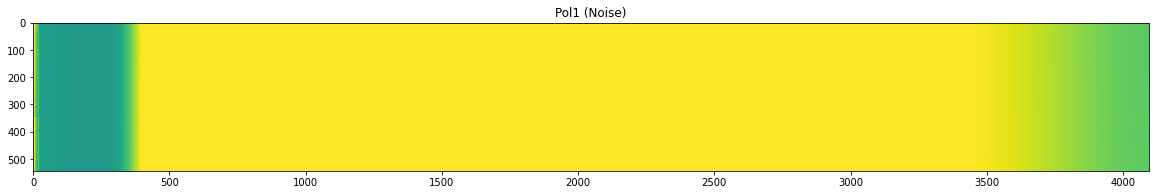

In [11]:
# Plots the 'short.scio' mode for the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(1, figsize=(20, 10))
plt.title('Pol1 (Short)')
plt.imshow(np.log10(short_data_pol1), vmin=4.5, vmax=8.5)

# Plots the 'res50.scio' mode for the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(2, figsize=(20, 10))
plt.title('Pol1 (50 Ohm)')
plt.imshow(np.log10(res50_data_pol1), vmin=4.5, vmax=8.5)

# Plots the 'res100.scio' mode for the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(3, figsize=(20, 10))
plt.title('Pol1 (100 Ohm)')
plt.imshow(np.log10(res100_data_pol1), vmin=4.5, vmax=8.5)

# Plots the 'noise.scio' mode for the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(3, figsize=(20, 10))
plt.title('Pol1 (Noise)')
plt.imshow(np.log10(noise_data_pol1), vmin=4.5, vmax=8.5)

The antenna data extracted above still shows some residual features caused by radio frequency interference (RFI). One of these resembles a vertical dashed line in the `pol1.scio` plot above. In order to mask such features we employ the `add_rfi_masks` function, which adds a new entry `RFI_masks` entry to the `prizm_data` dictionary.

In [15]:
pzt.add_rfi_masks(prizm_data, antennas=['70MHz'], threshold=8, median_filter_window=10)

To visualize the RFI masks produced by the above command, let us encapsulate the data and the RFI mask into a single object, and then plot using the same method used above. Notice how that the vertical dashed line caused by RFI has been removed, as well as many other features which are not so easily spotted by eye.

In [ ]:
# Creates a NumPy array equipped with the above-generated RFI mask.
rfi_masked_data = np.ma.masked_array(np.log10(antenna_data_pol1), mask=prizm_data['70MHz']['RFI_masks']['pol0.scio'])

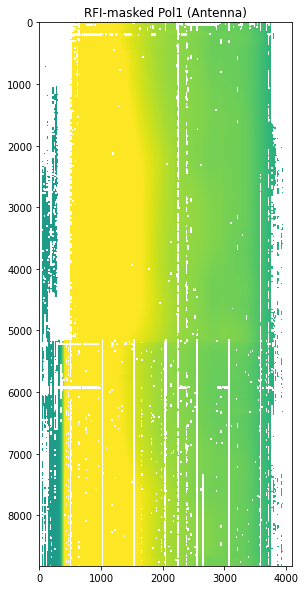

In [17]:
# Plots the 'antenna.scio' mode for the polarization channel 'Pol1' on a logarithmic color scale.
plt.figure(1, figsize=(10, 10))
plt.title('RFI-masked Pol1 (Antenna)')
plt.imshow(rfi_masked_data, vmin=4.5, vmax=8.5)

Let us now look at the horizontal cross-sections of the data. This will allow us to see more clearly the difference in the recorded spectrum for the different observing modes.

Below, we separate the data in each of its observing modes, and plot each of these with a different color.

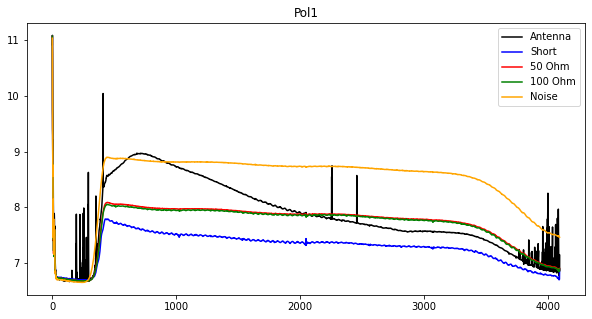

In [28]:
# Plots cross-sections of the 'pol1.scio' data associated with the different observing modes.
plt.figure(1, figsize=(10, 5))
plt.title('Pol1')
plt.plot(np.log10(antenna_data_pol1[100,:]), color='black', label='Antenna', alpha=1)
plt.plot(np.log10(short_data_pol1[100,:]), color='blue', label='Short', alpha=1)
plt.plot(np.log10(res50_data_pol1[100,:]), color='red', label='50 Ohm', alpha=1)
plt.plot(np.log10(res100_data_pol1[100,:]), color='green', label='100 Ohm', alpha=1)
plt.plot(np.log10(noise_data_pol1[100,:]), color='orange', label='Noise', alpha=1)

# Legend.
plt.legend(loc='best')